# 机器学习练习2-逻辑回归

在这次练习中，将实现逻辑回归并应用到一个分类任务中；还将正则化加入训练算法，并使用更复杂的情形来测试它。

## 逻辑回归

首先，构建一个逻辑回归模型，通过学生两次测试的评分，来预测某个大学生是否被大学录取。为完成该任务，我们准备构建一个基于两次测试评分来评估录取可能性的分类模型。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 设置 plt 画布特征
# plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
%matplotlib inline

In [3]:
path = 'ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam1', 'Exam2', 'Admitted'])
data.head()

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


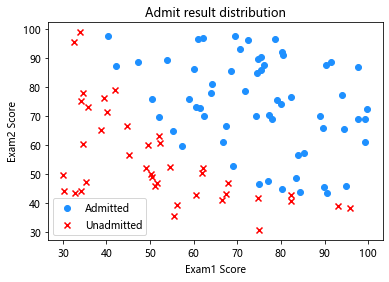

In [4]:
# 绘制散点图，查看接纳和未接纳的正负样本数据
pos = data[data['Admitted'].isin([1])]    # 筛选结果为1的行作为新dataframe
neg = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pos['Exam1'], pos['Exam2'], c='dodgerblue', marker='o', label='Admitted')
ax.scatter(neg['Exam1'], neg['Exam2'], c='red', marker='x', label='Unadmitted')
ax.legend()
ax.set_xlabel('Exam1 Score')
ax.set_ylabel('Exam2 Score')
ax.set_title('Admit result distribution')
plt.show()

观察数据，可以看到决策边界趋近于一条直线，因此可以尝试使用线性加 Sigmoid 拟合。

逻辑回归模型需要用到 Sigmoid 函数：

$$
g(z)=\frac{1}{1+e^{-z}}
$$

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

大致来看一下它的曲线

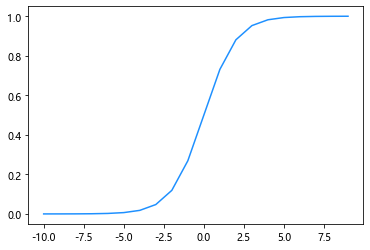

In [6]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(nums, sigmoid(nums), 'dodgerblue')
plt.show()

我们知道，逻辑回归模型的假设函数为：
$$
h_{\theta}(x)=g(\theta^{T}x)
$$

代价函数为：
$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [ y^{(i)}log(h_{\theta} (x^{(i)})) + (1-y^{(i)}) log(1-h_{\theta}(x^{(i)})) ]
$$

向量化表示：
$$
J(\theta) = \frac{1}{m} \cdot (-y^{T} log(h) - (1-y)^{T} log(1-h))
$$

In [7]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    return np.sum(first - second) / (len(X))

In [8]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

In [9]:
# 测试初始成本值
cost(theta, X, y)

0.6931471805599453

接下来看一下批量梯度下降算法：
$$
Repeat\ \{
\theta_{j}:=\theta_{j}-\frac{\alpha}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}
\}
$$

下面我们先来计算每一步优化，各参数值的变化，即：

$$
\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}
$$

In [10]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        grad[i] = np.sum(term) / len(X)
    
    return grad

In [11]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [12]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131866,   0.20623159,   0.20147149]), 36, 0)

In [13]:
# 优化后的成本
cost(result[0], X, y)

0.20349770158947447

In [14]:
# 预测值小于0.5时取0，反之取1
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [15]:
theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%


## 正则化逻辑回归

In [16]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test1', 'Test2', 'Accepted'])
data2.head()

,Test1,Test2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


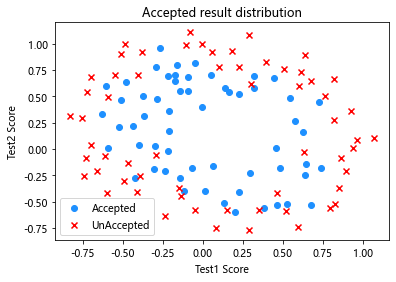

In [17]:
# 绘制散点图，查看接纳和未接纳的正负样本数据
pos = data2[data2['Accepted'].isin([1])]    # 筛选结果为1的行作为新dataframe
neg = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pos['Test1'], pos['Test2'], c='dodgerblue', marker='o', label='Accepted')
ax.scatter(neg['Test1'], neg['Test2'], c='red', marker='x', label='UnAccepted')
ax.legend()
ax.set_xlabel('Test1 Score')
ax.set_ylabel('Test2 Score')
ax.set_title('Accepted result distribution')
plt.show()

可以看到，这组数据的决策边界并不是线性的，因此我们并不能用线性模型去拟合，这里我们对原特征进行处理，将其合成多次多项式特征之和。

$$
\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \theta_{3}x_{1}^{2} + \theta_{4}x_{1}x_{2} + \theta_{5}x_{2}^{2} + \theta_{6}x_{1}^{2}x_{2} + \theta_{7}x_{1}x_{2}^{2}
$$

In [18]:
x1 = data2['Test1']
x2 = data2['Test2']

data2.insert(3, 'Ones', 1)

data2['F10'] = x1
data2['F01'] = x2
data2['F20'] = np.power(x1,2)
data2['F11'] = x1 * x2
data2['F02'] = np.power(x2,2)
data2['F21'] = np.power(x1,2) * x2
data2['F12'] = x1 * np.power(x2,2)

data2.drop('Test1', axis=1, inplace=True)
data2.drop('Test2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,F10,F01,F20,F11,F02,F21,F12
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.001839,0.025089
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,0.005891,-0.043509
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,0.031616,-0.102412
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,0.070620,-0.094573
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,0.122661,-0.111283


因为特征数目增多，我们将特征进行正则化；正则化逻辑回归的成本函数：

$$
J(\theta) =
\frac{1}{m} \sum_{i=1}^{m}
[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^{2}
$$

In [19]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

正则化逻辑回归的梯度下降算法：

$$
\mathbf{Repeat}\ \{
\begin{aligned}
\theta_{0} : &= \theta_{0} - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)}) x_{0}^{(i)}\\
\theta_{j} : &= \theta_{j} - \alpha [ \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)}) x_{j}^{(i)} + \frac{\lambda}{m} \theta_{j} ], \ j\in \{1,2,\cdots,n\}
\end{aligned}
\}
$$

In [20]:
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad

In [21]:
# set X and y (remember from above that we moved the label to column 0)
cols = data2.shape[1]
X2 = data2.iloc[:,1:cols]
y2 = data2.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(8)

In [22]:
learningRate = 1    # 暂时取1，后续可调整

In [23]:
costReg(theta2, X2, y2, learningRate)

0.6931471805599454

In [24]:
gradientReg(theta2, X2, y2, learningRate)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 7.32393391e-03, 8.19244468e-03])

In [25]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientReg, args=(X2, y2, learningRate))
result2

(array([ 1.20183793,  0.37813794,  0.70705086, -2.76170828, -0.88656047,
        -2.38918377, -0.35214178, -0.26341625]),
 24,
 1)

In [26]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 95%
